In [35]:
import tensorflow as tf
from tensorflow import keras
from keras import models,layers
import matplotlib.pyplot as plt

In [36]:
IMAGE_SIZE=256
CHANNELS=3
BATCH_SIZE=32
EPOCHS=50

In [37]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    '/content/PlantVillage', shuffle=True, image_size=(IMAGE_SIZE,IMAGE_SIZE), batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [38]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [39]:
#The length of the dataset based on the batches
len(dataset)

68

In [40]:
for image_batch, label_batch in dataset.take(1):
  print(image_batch.shape)
  print(label_batch.numpy)

(32, 256, 256, 3)
<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 2, 0, 0, 1, 1, 1, 0, 1, 0, 2, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 2, 1, 0], dtype=int32)>>


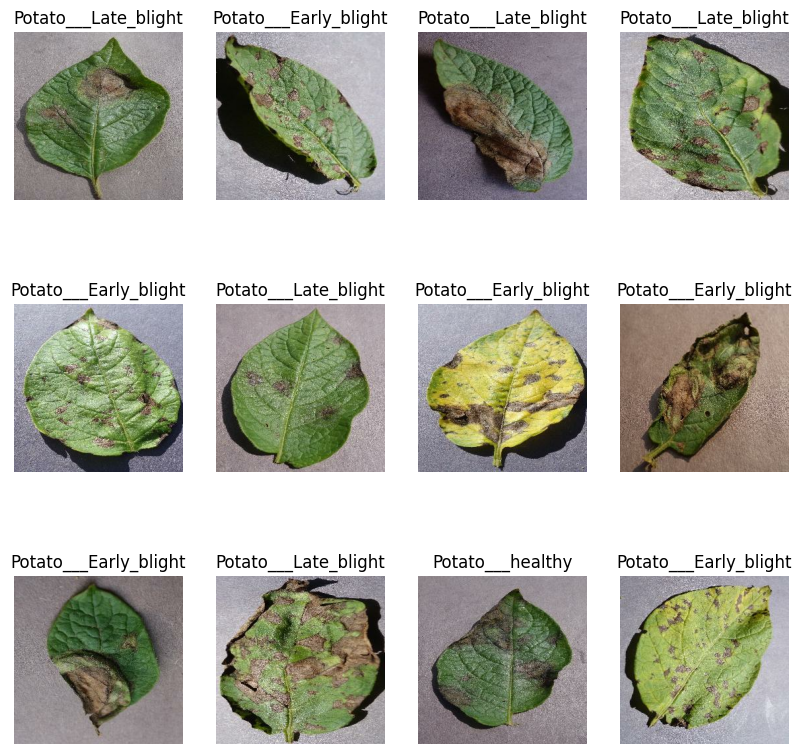

In [41]:
plt.figure(figsize=(10,10))
for image_batch, image_label in dataset.take(1):
  for i in range(12):
    ax=plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.title(class_names[label_batch[i]])
    plt.axis('off')

In [42]:
#Function to split the dataset into train and test

def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
  ds_size=len(ds)

  if shuffle:
    ds=ds.shuffle(shuffle_size,seed=12)

  train_size=int(train_split*ds_size)
  val_size=int(val_split*ds_size)

  train_ds=ds.take(train_size)
  val_ds=ds.skip(train_size).take(val_size)
  test_ds=ds.skip(train_size).skip(val_size)

  return train_ds,val_ds,test_ds



In [43]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

In [44]:
len(train_ds), len(val_ds), len(test_ds)

(54, 6, 8)

In [45]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [46]:
resize_and_rescale=keras.Sequential([
    layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

data_augmentation=keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2)
])

In [47]:
#Buiding the Model

input_shape=(IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=3

from keras import Input

model=models.Sequential([
    Input(shape=input_shape, batch_size=None),
    resize_and_rescale,
    data_augmentation,

    layers.Conv2D(32,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')

])



In [48]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_4 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [49]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [50]:
history=model.fit(train_ds,epochs=EPOCHS,batch_size=BATCH_SIZE,validation_data=val_ds)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 0.4847 - loss: 0.9627 - val_accuracy: 0.4948 - val_loss: 0.9480
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.5171 - loss: 0.8635 - val_accuracy: 0.7083 - val_loss: 0.6904
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.7758 - loss: 0.5839 - val_accuracy: 0.8229 - val_loss: 0.4284
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.8341 - loss: 0.4125 - val_accuracy: 0.8229 - val_loss: 0.3833
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.8880 - loss: 0.2946 - val_accuracy: 0.8646 - val_loss: 0.3056
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.8723 - loss: 0.2974 - val_accuracy: 0.8802 - val_loss: 0.2590
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.8902 - loss: 0.2603 - val_accuracy: 0.9219 - val_loss: 0.1945
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.9114 - loss: 0.2282 - val_accuracy: 0.8802 - v

In [51]:
history.params

{'verbose': 'auto', 'epochs': 50, 'steps': 54}

In [52]:
history.history['accuracy']

[0.49710649251937866,
 0.6111111044883728,
 0.7893518805503845,
 0.8420138955116272,
 0.890625,
 0.8888888955116272,
 0.8993055820465088,
 0.9021990895271301,
 0.9079861044883728,
 0.9334490895271301,
 0.9334490895271301,
 0.9340277910232544,
 0.9351851940155029,
 0.9502314925193787,
 0.9293981194496155,
 0.9484953880310059,
 0.9427083134651184,
 0.9594907164573669,
 0.9409722089767456,
 0.9589120149612427,
 0.9600694179534912,
 0.9600694179534912,
 0.9670138955116272,
 0.9704861044883728,
 0.9641203880310059,
 0.9594907164573669,
 0.9681712985038757,
 0.9699074029922485,
 0.9791666865348816,
 0.9681712985038757,
 0.9635416865348816,
 0.9745370149612427,
 0.9768518805503845,
 0.9756944179534912,
 0.9832175970077515,
 0.9809027910232544,
 0.9716435074806213,
 0.9866898059844971,
 0.9901620149612427,
 0.9809027910232544,
 0.9849537014961243,
 0.984375,
 0.9907407164573669,
 0.9785879850387573,
 0.9872685074806213,
 0.9809027910232544,
 0.9872685074806213,
 0.9849537014961243,
 0.98611110

In [53]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation loss')

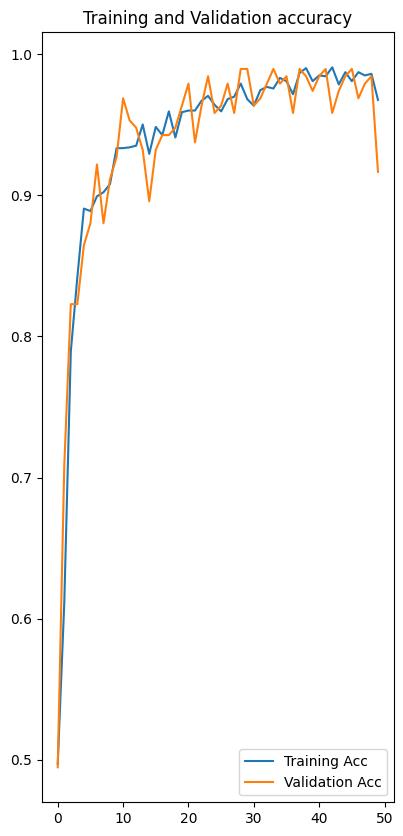

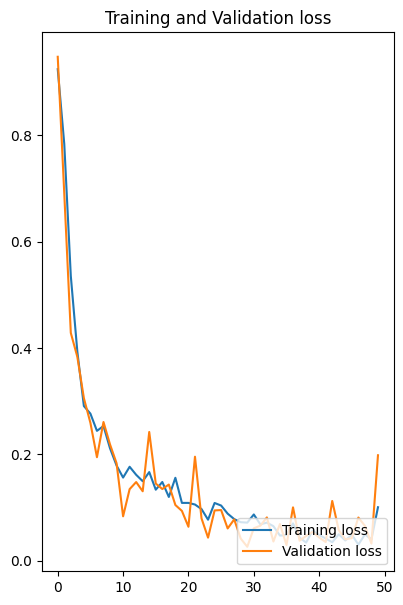

In [54]:
#Plotting the data
#Accuracy
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc ,label='Training Acc')
plt.plot(range(EPOCHS),val_acc ,label='Validation Acc')
plt.legend(loc='lower right')
plt.title('Training and Validation accuracy')



#Loss
plt.figure(figsize=(10,7))
plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss ,label='Training loss')
plt.plot(range(EPOCHS),val_loss ,label='Validation loss')
plt.legend(loc='lower right')
plt.title('Training and Validation loss')

first image to predict
actual label: Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
Predicted label: Potato___Early_blight


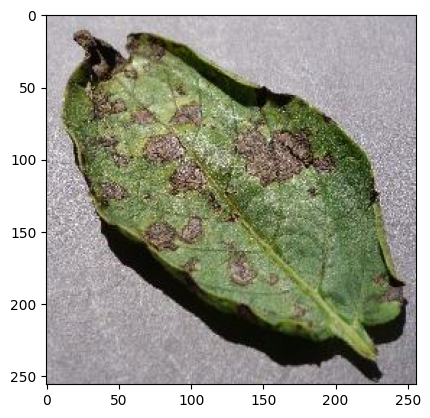

In [55]:
#comparing the predicted and the actual image
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
  first_image=images_batch[0].numpy().astype('uint8')
  first_label=labels_batch[0].numpy()

  print('first image to predict')
  plt.imshow(first_image)
  print('actual label:',class_names[first_label])

  batch_prediction=model.predict(images_batch)
  print('Predicted label:',class_names[np.argmax(batch_prediction[0])])

In [56]:
#The function to predict

def predict(model,img):
  img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array=tf.expand_dims(img_array, 0)
  predictions=model.predict(img_array)
  predicted_class=class_names[np.argmax(predictions[0])]
  confidence=round(100*(np.max(predictions[0])),2)
  return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


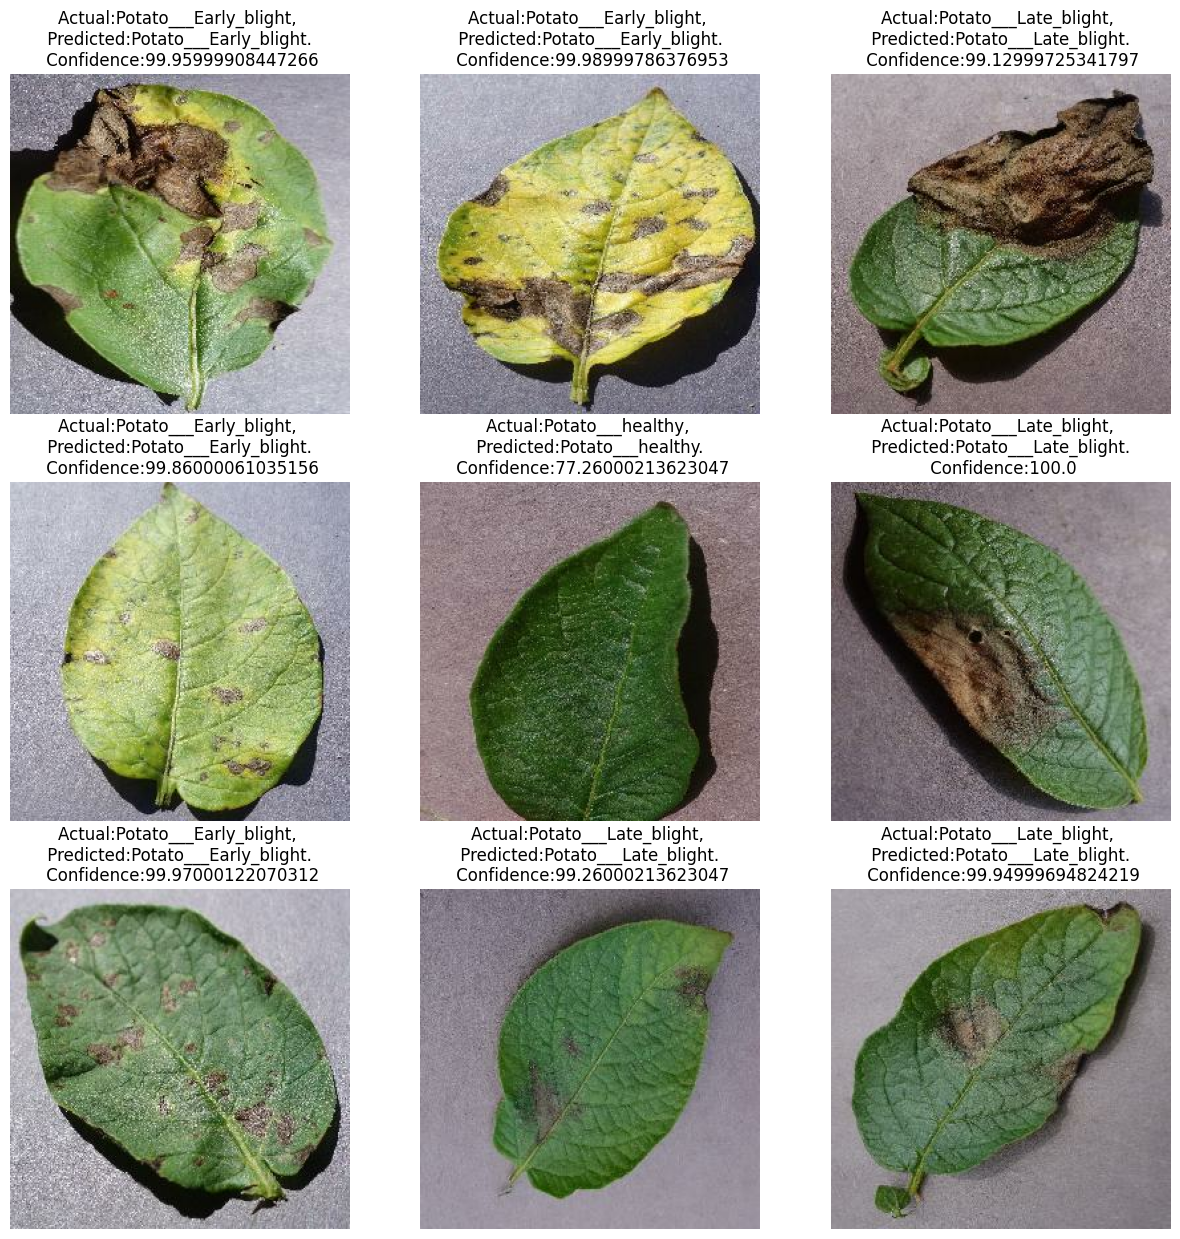

In [57]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax=plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))

    predicted_class,confidence = predict(model,images[i].numpy())
    actual_class=class_names[labels[i]]
    plt.title(f'Actual:{actual_class}, \n Predicted:{predicted_class}. \n Confidence:{confidence}')
    plt.axis('off')

In [61]:
#
model.save('plant_disease_model.keras')  # ✅ Recommended format

# Save class names
import pickle
with open('class_names.pkl', 'wb') as f:
    pickle.dump(class_names, f)